# Convolutional Neural Networks


In this notebook we are going to explore the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset (you don't need to download this dataset, we are going to use keras to download this dataset). This is a great dataset to train models for visual recognition and to start to build some models in Convolutional Neural Networks (CNN). This dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images

As CNN's requires high-computational effort, we are going to use a reduced version of this training dataset. Given our time and computational resources restrictions, we are going to select 3 categories (airplane, horse and truck).
 
In this notebook, we are going to build two different models in order to classify the objects. First, we are going to build Shallow Neural Network based just in a few Fully-Connected Layers (aka Multi-layer Perceptron) and we are going to understand why is not feasible to classify images with such networks. Then, we are going to build a CNN network to perform the same task and evaluate its performance.

Again, in order to have a clean notebook, some functions are implemented in the file *utils.py* (e.g., plot_loss_and_accuracy). 

Summary:
 - [Downloading CIFAR-10 Dataset](#cifar)
 - [Data Pre-processing](#reduce)
     - [Reducing the Dataset](#red)
     - [Normalising the Dataset](#normalise)
     - [One-hot Encoding](#onehot)
 - [Building  the Shallow Neural Network](#shallow)
     - [Training the Model](#train_shallow)
     - [Prediction and Performance Analysis](#performance_sh)
 - [Building the Convolutional Neural Network](#cnn)
     - [Training the Model](#train_cnn)
     - [Prediction and Performance Analysis](#performance_cnn)


In [25]:
# Standard libraries
import numpy as np  # written in C, is faster and robust library for numerical and matrix operations
import pandas as pd # data manipulation library, it is widely used for data analysis and relies on numpy library.
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # Plot nicely =) . Importing seaborn modifies the default matplotlib color schemes and plot 
                      # styles to improve readability and aesthetics.

# Auxiliar functions
from utils import *

# the following to lines will tell to the python kernel to always update the kernel for every utils.py
# modification, without the need of restarting the kernel.
%load_ext autoreload
%autoreload 2

# using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Downloading CIFAR-10 Dataset
<a id='cifar'></a>

Keras provides several [datasets](https://keras.io/datasets/) for experimentation, this makes it easy to try new network architectures. In order to download the CIFAR-10 dataset, we need to import the library "[cifar10](https://keras.io/datasets/#cifar100-small-image-classification)" and call the method *load_data()".

In [2]:
from keras.datasets import cifar10 # Implements the methods to dowload CIFAR-10 dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data() #this will download the dataset
# by defaul, the dataset was split in 50,000 images for training and 10,000 images for testing
# we are going to use this configuration

y_train = y_train.ravel() # Return a contiguous flattened y_train
y_test = y_test.ravel() #Return a contiguous flattened y_test

Let's visualise how the images looks like. To plot the images we are going to use the function **plot_images** (see *utils.py*)

____________________________________________________________________________________________

airplane - number of samples: 5000


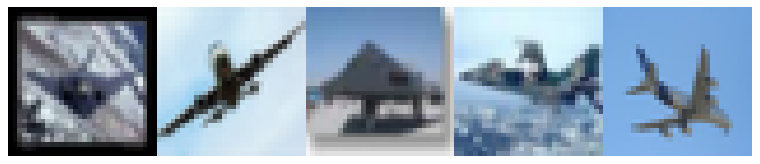

____________________________________________________________________________________________

automobile - number of samples: 5000


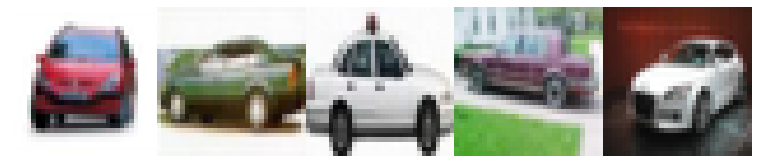

____________________________________________________________________________________________

bird - number of samples: 5000


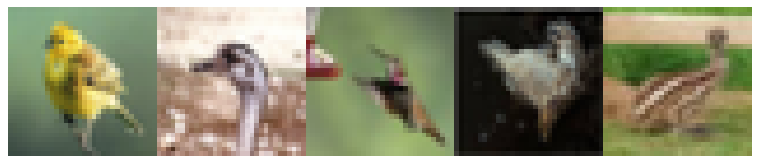

____________________________________________________________________________________________

cat - number of samples: 5000


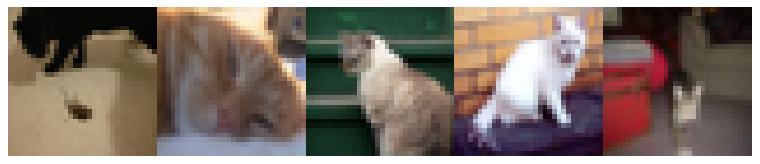

____________________________________________________________________________________________

deer - number of samples: 5000


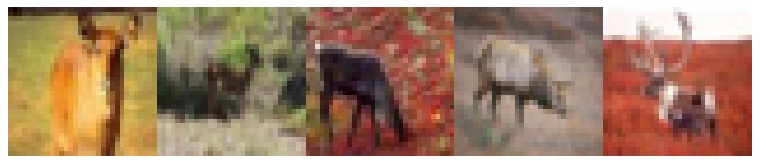

____________________________________________________________________________________________

dog - number of samples: 5000


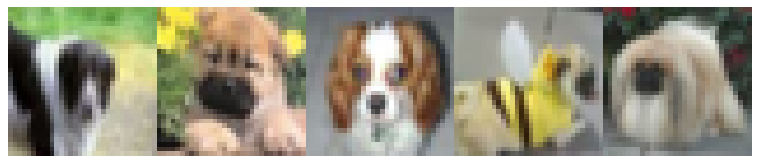

____________________________________________________________________________________________

frog - number of samples: 5000


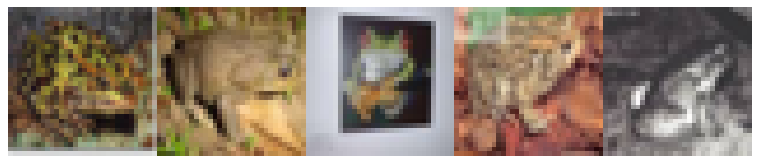

____________________________________________________________________________________________

horse - number of samples: 5000


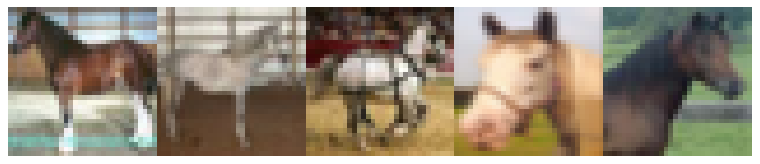

____________________________________________________________________________________________

ship - number of samples: 5000


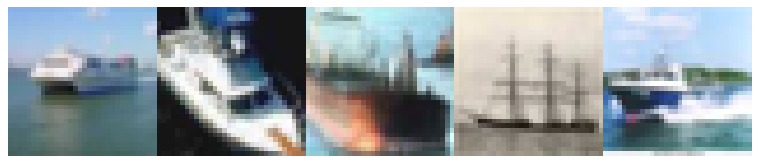

____________________________________________________________________________________________

truck - number of samples: 5000


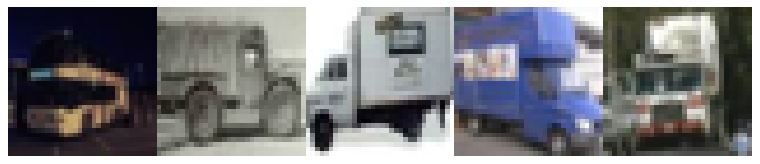

In [3]:
# from https://www.cs.toronto.edu/~kriz/cifar.html we can grab the class names
#                 0            1         2       3     4       5      6       7        8       9
class_name = np.array(
    ['airplane', 'automobile','bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# 
plot_samples(x_train, y_train, class_name)

## Data Pre-processing
<a id='reduce'></a>

As CNN's requires high-computational effort, we are going to use a reduced training dataset. Given our time and computational resources restrictions, we are going to select 3 categories (airplane, horse and truck) and for each category and select in total 1500 images.

Once obtained the reduced version, we are going to normalise the images and generate the one-hot enconding representation of the labels.

### Reducing the Dataset
<a id='red'></a>

In [4]:
# Lets select just 3 classes to make this tutorial feasible
selected_idx = np.array([0, 7, 9])
n_images = 1500

y_train_idx = np.isin(y_train, selected_idx)
y_test_idx = np.isin(y_test, selected_idx)

y_train_red = y_train[y_train_idx][:n_images]
x_train_red = x_train[y_train_idx][:n_images]

y_test_red = y_test[y_test_idx][:n_images]
x_test_red = x_test[y_test_idx][:n_images]

# replacing the labels 0, 7 and 9 to 0, 1, 2 repectively.
y_train_red[y_train_red == selected_idx[0]] = 0
y_train_red[y_train_red == selected_idx[1]] = 1
y_train_red[y_train_red == selected_idx[2]] = 2

y_test_red[y_test_red == selected_idx[0]] = 0
y_test_red[y_test_red == selected_idx[1]] = 1
y_test_red[y_test_red == selected_idx[2]] = 2

In [5]:
y_test_red[:4]

array([0, 0, 2, 1], dtype=uint8)

____________________________________________________________________________________________

airplane - number of samples: 508


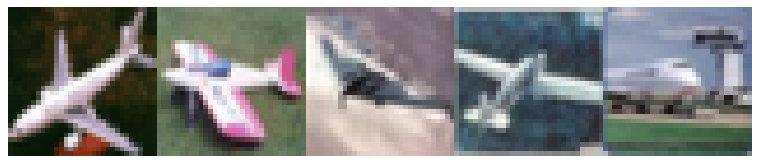

____________________________________________________________________________________________

horse - number of samples: 489


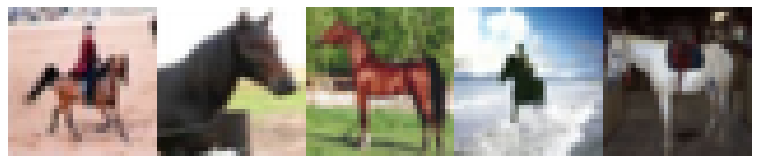

____________________________________________________________________________________________

truck - number of samples: 503


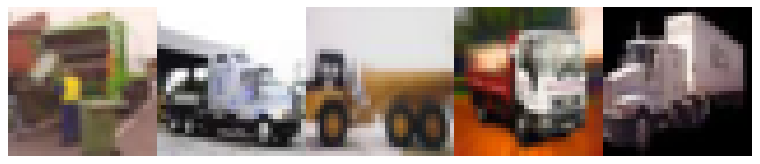

In [6]:
# visulising the images in the reduced dataset
plot_samples(x_train_red, y_train_red, class_name[selected_idx])

**Question 1**: Is the reduced dataset imbalanced?

**Question 2**: As you can see, the images have low resolution (32x32x3), how this can affect the model?

### Normalising the Dataset
<a id='normalise'></a>

Here we are going to normalise the dataset. In this task, we are going to divide each image by 255.0, as the images are represented as 'uint8' and we know that the range is from 0 to 255. By doing so, the range of the images will be between 0 and 1.

In [7]:
# Normalising the 
x_train_red = x_train_red.astype('float32')
x_test_red = x_test_red.astype('float32')
x_train_red /= 255.0
x_test_red /= 255.0

### One-hot Encoding
<a id='onehot'></a>

The labels are encoded as integers (0, 1 and 2), as we are going to use a *softmax layer* as output for our models we need to convert the labels as binary matrix. For example, the label 0 (considering that we have just 3 classes) can be represented as [1 0 0], which is the class 0.

One-hot enconding together with the sofmax function will give us an interesting interpretation of the output as a probability distribution over the classes. 

For this task, are going to use the function *[to_categorical](https://keras.io/utils/)*, which converts a class vector (integers) to binary class matrix.

In [8]:
y_train_oh = keras.utils.to_categorical(y_train_red)
y_test_oh = keras.utils.to_categorical(y_test_red)

print('Label: ',y_train_red[0], ' one-hot: ', y_train_oh[0])
print('Label: ',y_train_red[810], ' one-hot: ',  y_train_oh[810])
print('Label: ',y_test_red[20], ' one-hot: ', y_test_oh[20])

Label:  2  one-hot:  [0. 0. 1.]
Label:  0  one-hot:  [1. 0. 0.]
Label:  1  one-hot:  [0. 1. 0.]


## Building the Shallow Neural Network
<a id='shallow'></a>

Here we are going to build a Shallow Neural Network with 2 Fully Connected layers and one output layer. Basically, we are implemting a Multi-Layer Perceptron classifier.

To build the model, we are going use the following components from Keras:

 - [Sequencial](https://keras.io/models/sequential/): allows us to create models layer-by-layer. 
 - [Dense](https://keras.io/layers/core/): provides a regular fully-connected layer
 - [Dropout](https://keras.io/layers/core/#dropout): provides dropout regularisation

Basically, we are going to define the sequence of our model by using _Sequential()_, which include the layers:

```python
    model = Sequential()
    model.add(Dense(...))
    ...
```
once created the model we can configure the model for training by using the method [compile](https://keras.io/models/model/). Here we need to define the [loss](https://keras.io/losses/) function (mean squared error, categorical cross entropy, among others.), the [optimizer](https://keras.io/optimizers/) (Stochastic gradient descent, RMSprop, adam, among others) and the [metric](https://keras.io/metrics/) to define the evaluation metric to be used to evaluate the performance of the model in the training step, as follows:

```python
    model.compile(loss = "...", 
                  optimizer = "...")
```

Also, we have the option to see a summary representation of the model by using thebfunction [summary](https://keras.io/models/about-keras-models/#about-keras-models). This function summarise the model and tell us the number of parameters that we need to tune.

In [9]:
from keras.models import Sequential # implements sequential function
from keras.layers import Dense # implements the fully connected layer
from keras.layers import Dropout # implements Dropout regularisation
from keras.layers import Flatten # implements Flatten function

In [26]:
mlp = Sequential()

# Flatten will reshape the input an 1D array with dimension equal to 32 x 32 x 3 (3072)
# each pixel is an input for this model.
mlp.add(Flatten(input_shape=x_train_red.shape[1:])) #x_train.shape[1:] returns the shape 

# First layer with 1024 neurons and relu as activation function
mlp.add(Dense(1024, activation='relu'))
mlp.add(Dropout(0.7)) # regularization with 70% of keep probability

# Second layer with 1024 neurons and relu as activation function
mlp.add(Dense(1024, activation='relu'))
mlp.add(Dropout(0.7))# regularization with 70% of keep probability

# Output layer with 3 neurons and sofmax as activation function
mlp.add(Dense(y_test_oh.shape[1], activation='softmax'))

Summarising the model

In [11]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 4,199,427
Trainable params: 4,199,427
Non-

In [12]:
# Compile:
#  Optimiser: rmsprop
#  Loss: categorical_crossentropy, as our problem is multi-label classification
#  Metric: accuracy

mlp.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the Model
<a id=train_shallow></a>

Once defined the model, we need to train it by using the function [fit](https://keras.io/models/model/). This function performs the optmisation step. Hence, we can define the following parameters such as:

 - batch size: defines the number of samples that will be propagated through the network
 - epochs: defines the number of times in which all the training set (x_train_scaled) are used once to update the weights
 - validation split: defines the percentage of training data to be used for validation
 - among others (click [here](https://keras.io/models/model/) for more information)
 
This function return the _history_ of the training, that can be used for further performance analysis.

In [13]:
# training the model (this will take a few minutes)
history = mlp.fit(x_train_red, 
                    y_train_oh, 
                    batch_size = 256,
                    epochs = 100,
                    validation_split = 0.2,
                    verbose = 1)

Epoch 1/100
5/5 [==============================] - 1s 83ms/step - loss: 20.3799 - accuracy: 0.3283 - val_loss: 2.5529 - val_accuracy: 0.3667
Epoch 2/100
5/5 [==============================] - 0s 46ms/step - loss: 2.4466 - accuracy: 0.3567 - val_loss: 0.9969 - val_accuracy: 0.5800
Epoch 3/100
5/5 [==============================] - 0s 47ms/step - loss: 1.2306 - accuracy: 0.4133 - val_loss: 1.0007 - val_accuracy: 0.5400
Epoch 4/100
5/5 [==============================] - 0s 47ms/step - loss: 1.0657 - accuracy: 0.4650 - val_loss: 1.0229 - val_accuracy: 0.5467
Epoch 5/100
5/5 [==============================] - 0s 45ms/step - loss: 1.0786 - accuracy: 0.4400 - val_loss: 1.0043 - val_accuracy: 0.5233
Epoch 6/100
5/5 [==============================] - 0s 48ms/step - loss: 1.0671 - accuracy: 0.4392 - val_loss: 1.0182 - val_accuracy: 0.3967
Epoch 7/100
5/5 [==============================] - 0s 46ms/step - loss: 1.0701 - accuracy: 0.4683 - val_loss: 0.9894 - val_accuracy: 0.5867
Epoch 8/100
5/5 [==

5/5 [==============================] - 0s 43ms/step - loss: 0.8682 - accuracy: 0.6367 - val_loss: 0.9052 - val_accuracy: 0.5700
Epoch 60/100
5/5 [==============================] - 0s 44ms/step - loss: 0.9203 - accuracy: 0.6100 - val_loss: 0.8653 - val_accuracy: 0.6867
Epoch 61/100
5/5 [==============================] - 0s 43ms/step - loss: 0.7795 - accuracy: 0.6650 - val_loss: 0.8512 - val_accuracy: 0.6567
Epoch 62/100
5/5 [==============================] - 0s 44ms/step - loss: 0.7241 - accuracy: 0.7008 - val_loss: 0.8497 - val_accuracy: 0.6267
Epoch 63/100
5/5 [==============================] - 0s 44ms/step - loss: 0.8271 - accuracy: 0.6417 - val_loss: 0.8151 - val_accuracy: 0.6733
Epoch 64/100
5/5 [==============================] - 0s 43ms/step - loss: 0.8884 - accuracy: 0.6308 - val_loss: 0.8593 - val_accuracy: 0.6633
Epoch 65/100
5/5 [==============================] - 0s 43ms/step - loss: 0.8035 - accuracy: 0.6408 - val_loss: 0.8421 - val_accuracy: 0.6733
Epoch 66/100
5/5 [========

### Prediction and Performance Analysis
<a id='performance_sh'></a>

Here we plot the 'loss' and the 'Accuracy' from the training step.

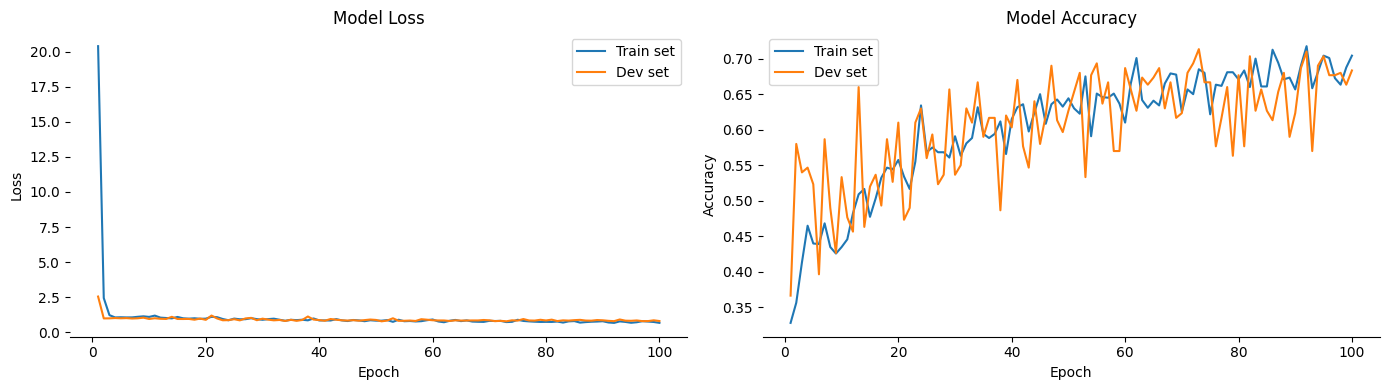

In [14]:
plot_loss_and_accuracy_am2(history=history)

Let's evaluate the performance of this model under unseen data (x_test)

In [15]:
loss_value_mlp, acc_value_mlp = mlp.evaluate(x_test_red, y_test_oh, verbose=0)
print('Loss value: ', loss_value_mlp)
print('Acurracy value: ', acc_value_mlp)

Loss value:  0.7757098078727722
Acurracy value:  0.6806666851043701


## Building the Convolutional Neural Network
<a id='cnn'></a>

Here we are going to build a Convolutional Neural Network (CNN) for image classification. Given the time and computational resources limitations, we are going to build a very simple CNN, however, more complex and deep CNN's architectures such as VGG, Inception and ResNet are the state of the art in computer vision and they superpass the human performance in image classification tasks. 

To build the model, we are going use the following components from Keras:

 - [Sequencial](https://keras.io/models/sequential/): allows us to create models layer-by-layer. 
 - [Dense](https://keras.io/layers/core/): provides a regular fully-connected layer
 - [Dropout](https://keras.io/layers/core/#dropout): provides dropout regularisation
 - [Conv2D](https://keras.io/layers/convolutional/): implement 2D convolution function
 - [BatchNormalization](https://keras.io/layers/normalization/): normalize the activations of the previous layer at each batch
 - [MaxPooling2D](https://keras.io/layers/pooling/): provides pooling operation for spatial data
 
Basically, we are going to define the sequence of our model by using _Sequential()_, which include the layers:

```python
    model = Sequential()
    model.add(Conv2D(...))
    ...
```
once created the model the training configuration is the same as [before](#shallow):

```python
    model.compile(loss = "...", 
                  optimizer = "...")
```

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout, Conv2D, MaxPooling2D, BatchNormalization

In [17]:
model_cnn = Sequential()

# First layer:
#  2D convolution:
#     Depth: 32
#     Kernel shape: 3 x 3
#     Stride: 1 (default)
#     Activation layer: relu
#     Padding: valid
#     Input shape: 32 x 32 x 3 (3D representation, not Flatten as MLP)
# as you can see now the input is an image and not an flattened array
model_cnn.add(Conv2D(32, (3, 3), padding='valid', activation = 'relu', 
                 input_shape=x_train_red.shape[1:]))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(5,5))) # max pooling with kernel size 5x5
model_cnn.add(Dropout(0.7)) # 70% of keep probability


# Second layer:
#  2D convolution:
#     Depth: 64
#     Kernel shape: 3 x 3
#     Stride: 1 (default)
#     Activation layer: relu
#     Padding: valid
model_cnn.add(Conv2D(64, (3, 3), padding='valid', activation = 'relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.7))

# Flatten the output from the second layer to become the input of the Fully-connected
# layer (flattened representation as MLP)
model_cnn.add(Flatten())

# First fully-connected layer with 128 neurons and relu as activation function
model_cnn.add(Dense(128, activation = 'relu'))

# Output layer with 3 neurons and sofmax as activation function
model_cnn.add(Dense(y_test_oh.shape[1], activation='softmax'))

Summarising the model

In [18]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 32)         0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 64)        

As you can see, the CNN model (53,059 parameters) has less parameters than the MLP model (4,199,427 parameters). So this model is less prone to overfit.

In [19]:
# Compile:
#  Optimiser: adam
#  Loss: categorical_crossentropy, as our problem is multi-label classification
#  Metric: accuracy

model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the Model
<a id=train_cnn></a>

In [20]:
# this will take a few minutes
history_cnn = model_cnn.fit(x_train_red, 
                    y_train_oh, 
                    batch_size = 256,
                    epochs = 100,
                    validation_split = 0.2,
                    verbose = 1)

Epoch 1/100
5/5 [==============================] - 1s 84ms/step - loss: 2.3850 - accuracy: 0.3250 - val_loss: 1.0966 - val_accuracy: 0.3667
Epoch 2/100
5/5 [==============================] - 0s 50ms/step - loss: 1.9281 - accuracy: 0.3858 - val_loss: 1.0863 - val_accuracy: 0.4167
Epoch 3/100
5/5 [==============================] - 0s 49ms/step - loss: 1.6755 - accuracy: 0.4108 - val_loss: 1.0766 - val_accuracy: 0.4267
Epoch 4/100
5/5 [==============================] - 0s 48ms/step - loss: 1.4740 - accuracy: 0.4625 - val_loss: 1.0710 - val_accuracy: 0.4333
Epoch 5/100
5/5 [==============================] - 0s 47ms/step - loss: 1.3155 - accuracy: 0.5117 - val_loss: 1.0608 - val_accuracy: 0.4367
Epoch 6/100
5/5 [==============================] - 0s 50ms/step - loss: 1.2375 - accuracy: 0.5183 - val_loss: 1.0509 - val_accuracy: 0.4567
Epoch 7/100
5/5 [==============================] - 0s 53ms/step - loss: 1.1914 - accuracy: 0.5417 - val_loss: 1.0411 - val_accuracy: 0.4700
Epoch 8/100
5/5 [===

5/5 [==============================] - 0s 52ms/step - loss: 0.6184 - accuracy: 0.7525 - val_loss: 0.8479 - val_accuracy: 0.5867
Epoch 60/100
5/5 [==============================] - 0s 51ms/step - loss: 0.5964 - accuracy: 0.7558 - val_loss: 0.8304 - val_accuracy: 0.6033
Epoch 61/100
5/5 [==============================] - 0s 47ms/step - loss: 0.5839 - accuracy: 0.7633 - val_loss: 0.7900 - val_accuracy: 0.6400
Epoch 62/100
5/5 [==============================] - 0s 50ms/step - loss: 0.5749 - accuracy: 0.7700 - val_loss: 0.7291 - val_accuracy: 0.6700
Epoch 63/100
5/5 [==============================] - 0s 47ms/step - loss: 0.6196 - accuracy: 0.7550 - val_loss: 0.6883 - val_accuracy: 0.6867
Epoch 64/100
5/5 [==============================] - 0s 47ms/step - loss: 0.5971 - accuracy: 0.7525 - val_loss: 0.6607 - val_accuracy: 0.7100
Epoch 65/100
5/5 [==============================] - 0s 50ms/step - loss: 0.5893 - accuracy: 0.7792 - val_loss: 0.6741 - val_accuracy: 0.7033
Epoch 66/100
5/5 [========

### Prediction and Performance Analysis
<a id='performance_cnn'></a>

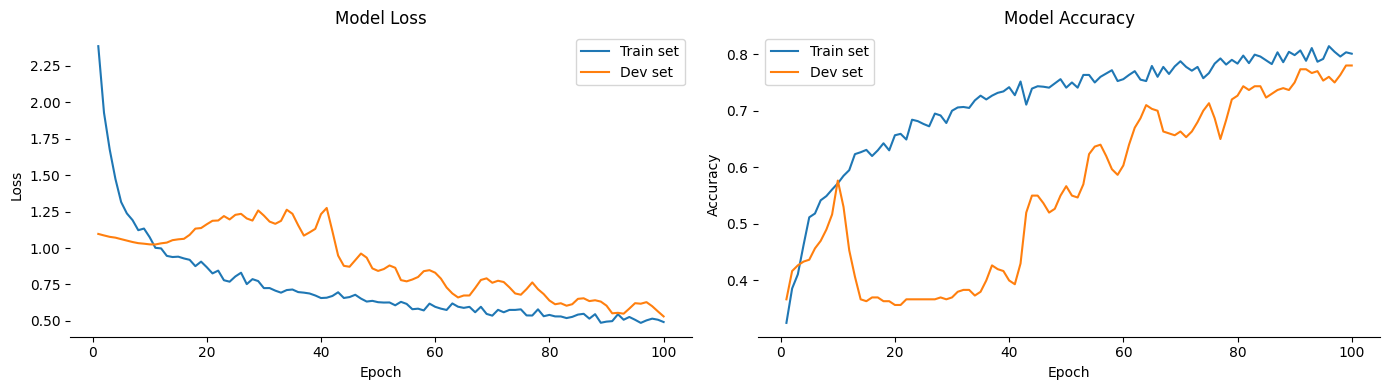

In [21]:
plot_loss_and_accuracy_am2(history=history_cnn)

Let's evaluate the performance of this model under unseen data (x_test)

In [22]:
model_cnn.evaluate(x_test_red,y_test_oh)

loss_value_cnn, acc_value_cnn = model_cnn.evaluate(x_test_red, y_test_oh, verbose=0)
print('Loss value: ', loss_value_cnn)
print('Acurracy value: ', acc_value_cnn)

47/47 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.7547
Loss value:  0.6216283440589905
Acurracy value:  0.7546666860580444


**Task**: Discuss CNN and MLP results.

**Your Turn**: Now we changed our mind, we found that detecting airplanes, horses and trucks is a bit boring :(. We would like to detect whether an image has a bird, a dog or a ship =)

Implement a CNN to classify the images of the new reduced dataset.

**Creating the dataset**

____________________________________________________________________________________________

bird - number of samples: 513


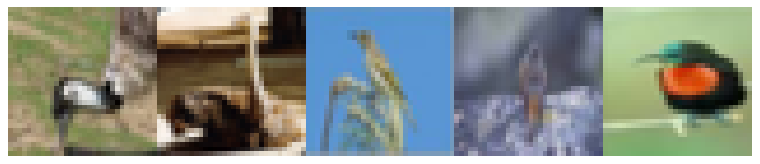

____________________________________________________________________________________________

dog - number of samples: 480


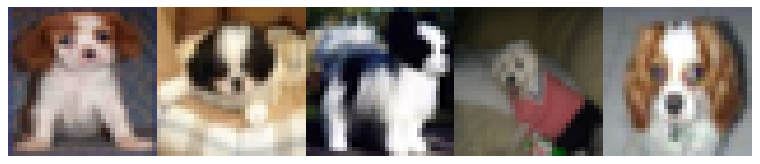

____________________________________________________________________________________________

ship - number of samples: 507


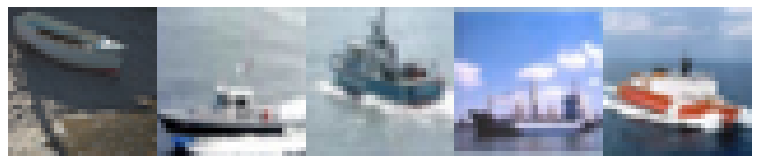

In [23]:
# Lets select just 3 classes to make this tutorial feasible
selected_idx = np.array([2, 5, 8])
n_images = 1500

y_train_idx = np.isin(y_train, selected_idx)
y_test_idx = np.isin(y_test, selected_idx)

y_train_new = y_train[y_train_idx][:n_images]
x_train_new = x_train[y_train_idx][:n_images]

y_test_new = y_test[y_test_idx][:n_images]
x_test_new = x_test[y_test_idx][:n_images]

# replacing the labels 0, 7 and 9 to 0, 1, 2 repectively.
y_train_new[y_train_new == selected_idx[0]] = 0
y_train_new[y_train_new == selected_idx[1]] = 1
y_train_new[y_train_new == selected_idx[2]] = 2

y_test_new[y_test_new == selected_idx[0]] = 0
y_test_new[y_test_new == selected_idx[1]] = 1
y_test_new[y_test_new == selected_idx[2]] = 2

# visulising the images in the reduced dataset
plot_samples(x_train_new, y_train_new, class_name[selected_idx])

**Pre-processing the new dataset**

In [24]:
# normalising the data
x_train_new = x_train_new.astype('float32')
x_test_new = x_test_new.astype('float32')
x_train_new /= 255.0
x_test_new /= 255.0

# creating the one-hot representation
y_train_oh_n = keras.utils.to_categorical(y_train_new)
y_test_oh_n = keras.utils.to_categorical(y_test_new)

print('Label: ',y_train_new[0], ' one-hot: ', y_train_oh_n[0])
print('Label: ',y_train_new[810], ' one-hot: ',  y_train_oh_n[810])
print('Label: ',y_test_new[20], ' one-hot: ', y_test_oh_n[20])

Label:  0  one-hot:  [1. 0. 0.]
Label:  1  one-hot:  [0. 1. 0.]
Label:  2  one-hot:  [0. 0. 1.]


**Step 1**: Create the CNN Model.

For example, you can try (Danger, Will Robinson! This model can overfits):

```python
model_cnn_new = Sequential()

model_cnn_new.add(Conv2D(32, (3, 3), padding='valid', activation = 'relu', 
                 input_shape=x_train_new.shape[1:]))
model_cnn_new.add(BatchNormalization())
model_cnn_new.add(MaxPooling2D(pool_size=(2,2))) 
model_cnn_new.add(Dropout(0.7))

# You can stack several convolution layers before apply BatchNormalization, MaxPooling2D
# and Dropout
model_cnn_new.add(Conv2D(32, (3, 3), padding='valid', activation = 'relu', 
                 input_shape=x_train_new.shape[1:]))
model_cnn_new.add(Conv2D(16, (3, 3), padding='valid', activation = 'relu'))
model_cnn_new.add(Conv2D(64, (3, 3), padding='valid', activation = 'relu'))
model_cnn_new.add(BatchNormalization())
# You can also don't use max pooling... it is up to you
#model_cnn_new.add(MaxPooling2D(pool_size=(2,2)))  # this line can lead to negative dimension problem
model_cnn_new.add(Dropout(0.7))

model_cnn_new.add(Conv2D(32, (5, 5), padding='valid', activation = 'relu'))
model_cnn_new.add(BatchNormalization())
model_cnn_new.add(MaxPooling2D(pool_size=(2,2)))
model_cnn_new.add(Dropout(0.7))

model_cnn_new.add(Flatten())
model_cnn_new.add(Dense(128, activation = 'relu'))

model_cnn_new.add(Dense(y_test_oh_n.shape[1], activation='softmax'))
```

**Step 2**: Summarise the model.

For example, you can try:

```python
model_cnn_new.summary()
```

**Step 3**: Define optimiser (try 'rmsprop', 'sgd', 'adagrad' or 'adadelta' if you wich), loss and metric
 
For example:
``` python
model_cnn_new.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
```

**Step 4**: Train the model, here you can define the number of epochs and batch_size that best fit for you model

For example:  
```python 
# this can take SEVERAL minutes or even hours.. days... if your model is quite deep
history_cnn_new = model_cnn_new.fit(x_train_new, 
                    y_train_oh_n, 
                    batch_size = 256,
                    epochs = 100,
                    validation_split = 0.2,
                    verbose = 1)
```

**Step 4**: Evaluate the model performance by using the metric that you think is the best.

For example:  
```python 
model_cnn_new.evaluate(x_test_new,y_test_oh_n)

loss_value_cnn_n, acc_value_cnn_n = model_cnn_new.evaluate(x_test_new, y_test_oh_n, verbose=0)
print('Loss value: ', loss_value_cnn_n)
print('Acurracy value: ', acc_value_cnn_n)
```

Plot the loss and accuracy if you which.